<img src='app/static/img/logo.png' style="display: block; margin: auto;" width='120'>

# Table of Contents
* [Import Libraries](#import-libraries)
* [Connect to Database](#connect-to-database)
* [Load Data](#load-data)
* [Pivot Table](#pivot-table)
* [Save Feature Names Order](#save-feature-names-order)
* [Pulling Label from Video table and merging it](#pulling-label-from-video-table-and-merging-it)
* [Create Time Series Tensor](#create-time-series-tensor)
* [Seperate Feature Matrix and Label Vector](#separate-feature-matrix-and-label-vector)
* [Label Encoder + One-Hot Encoder](#label-encoder--one-hot)
* [Scaling](#scaling)
* [Split Data into Train and Test Sets](#split-data-into-train-and-test-sets)
* [Configure Tensorboard](#configure-tensorboard)
* [Build LSTM Model](#build-lstm-model)
  * [Compile Model](#compile-model)
  * [Set Callbacks](#set-callbacks)
  * [Start Tensorboard](#start-tensorboard)
  * [Train Model](#train-model)
  * [Training History](#training-history)
* [Evaluate](#evaluate-model)
  * [Accuracy](#accuracy)
  * [Classification Report](#classification-report)
  * [Confusion Matrix](#confusion-matrix)
* [t-SNE](#t-sne)
  * [Create Intermediate Layer for t-SNE](#create-intermediate-layer-for-t-sne)
  * [Get Intermediate Layer Output](#get-intermediate-layer-output)
  * [Reduction to 2D Space with t-SNE](#reduction-to-2d-space-with-t-sne)
  * [Visualize t-SNE](#visualize-t-sne)
* [Save the Model, LabelEncoder and Scaler](#save-the-model-labelencoder-and-scaler)

# Import Libraries

In [2]:
pip install seaborn


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
)

# Connect to Database

In [102]:
engine = create_engine('sqlite:///app/sign-language-recognition.sqlite')

# Load Data

In [103]:
df = pd.read_sql('SELECT * FROM video_feature', engine)

In [104]:
df.head()

,id,video_id,feature_name,value,start_frame,end_frame
0,973,7,left_tips_x_mean,0.0,1,7
1,974,7,left_tips_x_std,0.0,1,7
2,975,7,left_tips_y_mean,0.0,1,7
3,976,7,left_tips_y_std,0.0,1,7
4,977,7,left_tips_z_mean,0.0,1,7


# Pivot Table

Her pencere (start_frame, video_id) için tüm feature_name → value’ları pivot yapıyoruz.

In [105]:
pivot = df.pivot_table(
    index=["video_id", "start_frame", "end_frame"],
    columns="feature_name",
    values="value",
).reset_index()

In [106]:
pivot.head()

feature_name,video_id,start_frame,end_frame,joints_x_mean,joints_x_std,joints_y_mean,joints_y_std,joints_z_mean,joints_z_std,left_tips_x_mean,...,left_tips_y_mean,left_tips_y_std,left_tips_z_mean,left_tips_z_std,right_tips_x_mean,right_tips_x_std,right_tips_y_mean,right_tips_y_std,right_tips_z_mean,right_tips_z_std
0,4,29,35,0.548170,0.225704,0.800081,0.152409,-0.790245,0.592218,0.726475,...,0.657858,0.079329,-0.075803,0.024827,0.747947,0.183402,0.709833,0.146383,-0.026014,0.042567
1,4,36,42,0.537487,0.230806,0.819116,0.152344,-0.794925,0.597455,0.734043,...,0.738434,0.113980,-0.068004,0.020464,0.675279,0.121153,0.701759,0.144232,-0.060615,0.021091
2,4,43,49,0.529866,0.247732,0.834300,0.154013,-0.884728,0.641592,0.659292,...,0.700432,0.052022,-0.055877,0.018779,0.592951,0.198292,0.708321,0.054428,-0.061114,0.014330
3,4,50,56,0.524069,0.235167,0.815957,0.143095,-0.698056,0.590248,0.191358,...,0.770209,0.040239,-0.046355,0.012464,0.197729,0.052888,0.730361,0.020888,-0.023302,0.004176
4,4,57,63,0.517239,0.247968,0.876815,0.172278,-0.627591,0.491813,0.339411,...,0.952566,0.038597,-0.036325,0.009488,0.555496,0.029888,0.942637,0.039485,-0.040102,0.006510


# Save Feature Names Order

for later use prediction

In [107]:
feature_columns = pivot.columns.drop(['video_id', 'start_frame', 'end_frame']).tolist()

with open("app/model/feature_order.json", "w") as f:
    json.dump(feature_columns, f)

# Pulling Label from Video table and merging it

In [108]:
videos = pd.read_sql('SELECT id, label FROM video', engine)
data = pivot.merge(videos, left_on='video_id', right_on='id')

In [109]:
data.head()

,video_id,start_frame,end_frame,joints_x_mean,joints_x_std,joints_y_mean,joints_y_std,joints_z_mean,joints_z_std,left_tips_x_mean,...,left_tips_z_mean,left_tips_z_std,right_tips_x_mean,right_tips_x_std,right_tips_y_mean,right_tips_y_std,right_tips_z_mean,right_tips_z_std,id,label
0,4,29,35,0.548170,0.225704,0.800081,0.152409,-0.790245,0.592218,0.726475,...,-0.075803,0.024827,0.747947,0.183402,0.709833,0.146383,-0.026014,0.042567,4,CARRY
1,4,36,42,0.537487,0.230806,0.819116,0.152344,-0.794925,0.597455,0.734043,...,-0.068004,0.020464,0.675279,0.121153,0.701759,0.144232,-0.060615,0.021091,4,CARRY
2,4,43,49,0.529866,0.247732,0.834300,0.154013,-0.884728,0.641592,0.659292,...,-0.055877,0.018779,0.592951,0.198292,0.708321,0.054428,-0.061114,0.014330,4,CARRY
3,4,50,56,0.524069,0.235167,0.815957,0.143095,-0.698056,0.590248,0.191358,...,-0.046355,0.012464,0.197729,0.052888,0.730361,0.020888,-0.023302,0.004176,4,CARRY
4,4,57,63,0.517239,0.247968,0.876815,0.172278,-0.627591,0.491813,0.339411,...,-0.036325,0.009488,0.555496,0.029888,0.942637,0.039485,-0.040102,0.006510,4,CARRY


# Create Time Series Tensor

In [110]:
sequence_length = 5  # Kaç ardışık pencere bir örnek oluşturacak?

samples = []
labels = []

for vid, group in data.groupby("video_id"):
    group = group.sort_values("start_frame")
    
    # Etiketleri aynı kalacak şekilde sadece özellikleri al
    feats = group.drop(columns=['video_id','start_frame','end_frame','id','label']).values
    lbls = group['label'].values

    # Kaydırmalı pencere üret
    for i in range(len(feats) - sequence_length + 1):
        window = feats[i:i+sequence_length]
        label = lbls[i + sequence_length - 1]  # son pencerenin etiketi
        samples.append(window)
        labels.append(label)

# Separate feature matrix and label vector

In [111]:
X = np.array(samples, dtype=np.float32)
y_raw = np.array(labels)

# Label encoder + one-hot

In [112]:
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
y = to_categorical(y_int)

In [113]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (9096, 5, 18)
y.shape: (9096, 40)


# Scaling

In [114]:
scaler = StandardScaler()
X_reshaped = X.reshape(X.shape[0] * X.shape[1], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape[0], X.shape[1], -1)

# Split Data into Train and Test Sets

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (7276, 5, 18) (7276, 40)
Test set: (1820, 5, 18) (1820, 40)


# Configure Tensorboard

In [116]:
log_dir = "log/" + tf.timestamp().numpy().astype(str)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Clear any logs from previous runs
# !rm -rf ./log/

# Build LSTM Model

In [117]:
input_timesteps = X_train.shape[1]     # sequence length (örnek: 5)
input_features = X_train.shape[2]      # feature sayısı (örnek: 18 veya daha fazla)
num_classes = y_train.shape[1]         # sınıf sayısı (örnek: 11)

In [118]:
input_layer = Input(shape=(input_timesteps, input_features))
x = LSTM(128, return_sequences=True, name="lstm_1")(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = LSTM(64, name="lstm_2")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model

In [119]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [120]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,200 (516.41 KB)

 Trainable params: 131,816 (514.91 KB)

 Non-trainable params: 384 (1.50 KB)

# Set Callbacks

In [121]:
callbacks = [
    ModelCheckpoint(
        filepath='app/model/sign_language_recognition.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    EarlyStopping(patience=10, restore_best_weights=True),
    tensorboard
]

# Start Tensorboard

In [122]:
%load_ext tensorboard
%tensorboard --logdir=log/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 90125), started 5:48:15 ago. (Use '!kill 90125' to kill it.)

# Train Model

In [123]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/150
169/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0455 - loss: 3.8192
Epoch 1: val_loss improved from None to 3.40814, saving model to app/model/sign_language_recognition.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0754 - loss: 3.6178 - val_accuracy: 0.1758 - val_loss: 3.4081 - learning_rate: 0.0010
Epoch 2/150
179/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1489 - loss: 3.1589
Epoch 2: val_loss improved from 3.40814 to 2.73342, saving model to app/model/sign_language_recognition.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1675 - loss: 3.0790 - val_accuracy: 0.3056 - val_loss: 2.7334 - learning_rate: 0.0010
Epoch 3/150
168/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2119 - loss: 2.8411
Epoch 3: val_loss improved from 2.73342 to 2.41532, saving model to app/model/sign_language_recognition.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2230 - loss: 2.7961 - val_accuracy: 0.3310 - val_loss: 2.4153 - learning_ra

# Training History

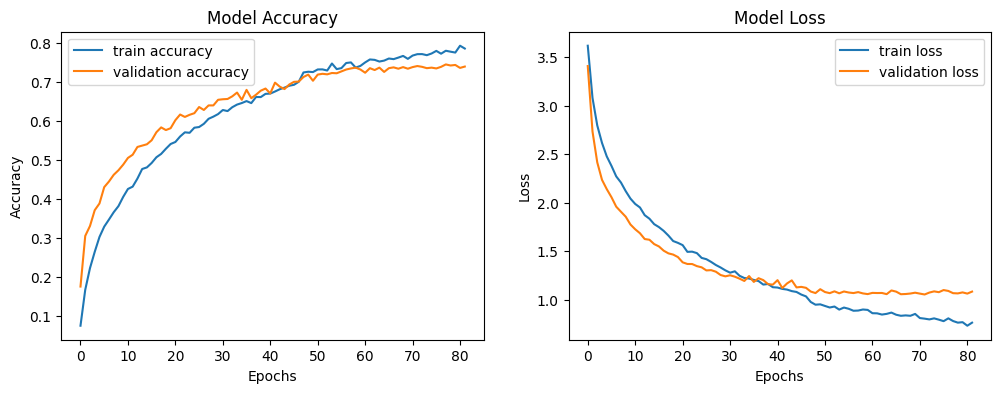

In [124]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model

## Accuracy

In [125]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7385 - loss: 1.0744
Test Accuracy: 0.7385, Test Loss: 1.0744


## Classification Report

In [126]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

       ABOUT       0.74      0.52      0.61        54
      ASSIST       0.79      0.70      0.74        47
         BAD       0.59      0.69      0.64        39
       CARRY       0.38      0.83      0.52        53
   CHRISTMAS       0.89      0.81      0.85        42
        DATE       0.75      0.83      0.78        46
      DINNER       0.91      0.62      0.74        52
      DOCTOR       0.68      0.48      0.56        48
         END       0.82      0.69      0.75        39
     ENGLISH       0.82      0.76      0.79        42
     EXAMPLE       0.59      0.79      0.68        48
         FAR       0.74      0.70      0.72        46
     FINANCE       0.79      0.78      0.78        49
        GIVE       0.85      0.76      0.80        37
        GOOD       0.90      0.63      0.74        41
    HOSPITAL       0.84      0.73      0.78        44
         HOW       0.85      0.71      0.7

## Confusion Matrix

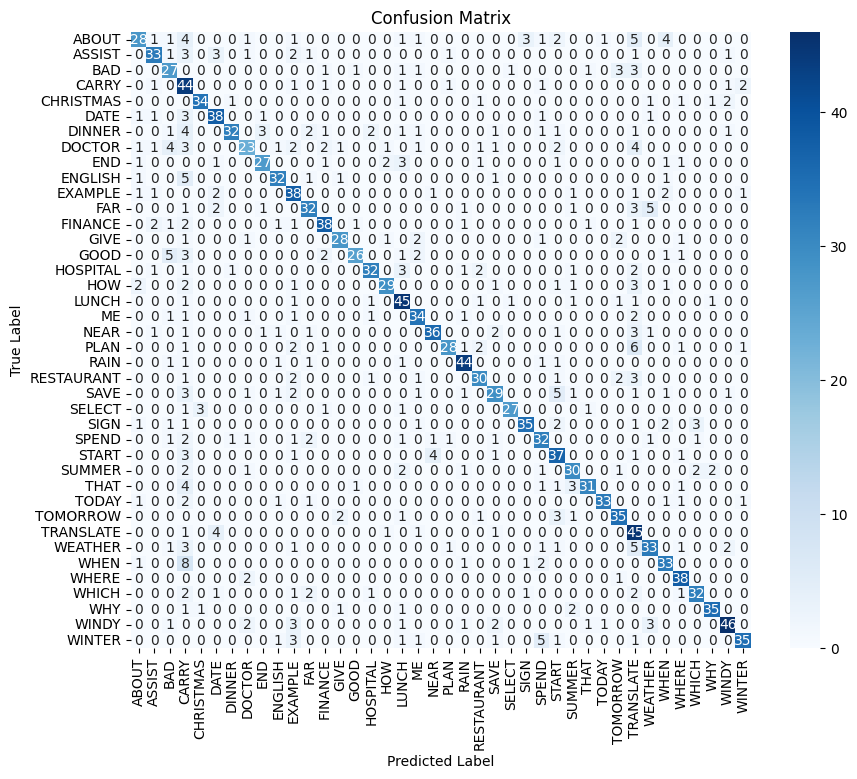

In [127]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# t-SNE
## Create Intermediate Layer for t-SNE

In [128]:
intermediate_layer_model = Model(
    inputs=model.input, outputs=model.get_layer("lstm_2").output
)

## Get Intermediate Layer Output

In [129]:
X_train_lstm = intermediate_layer_model.predict(X_train)
X_test_lstm = intermediate_layer_model.predict(X_test)

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step


## Reduction to 2D Space with t-SNE

In [130]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_test_lstm)

## Visualize t-SNE

In [131]:
# One-hot vektörü -> sınıf etiketine dönüştür
y_test_int = np.argmax(y_test, axis=1)
labels = le.inverse_transform(y_test_int)

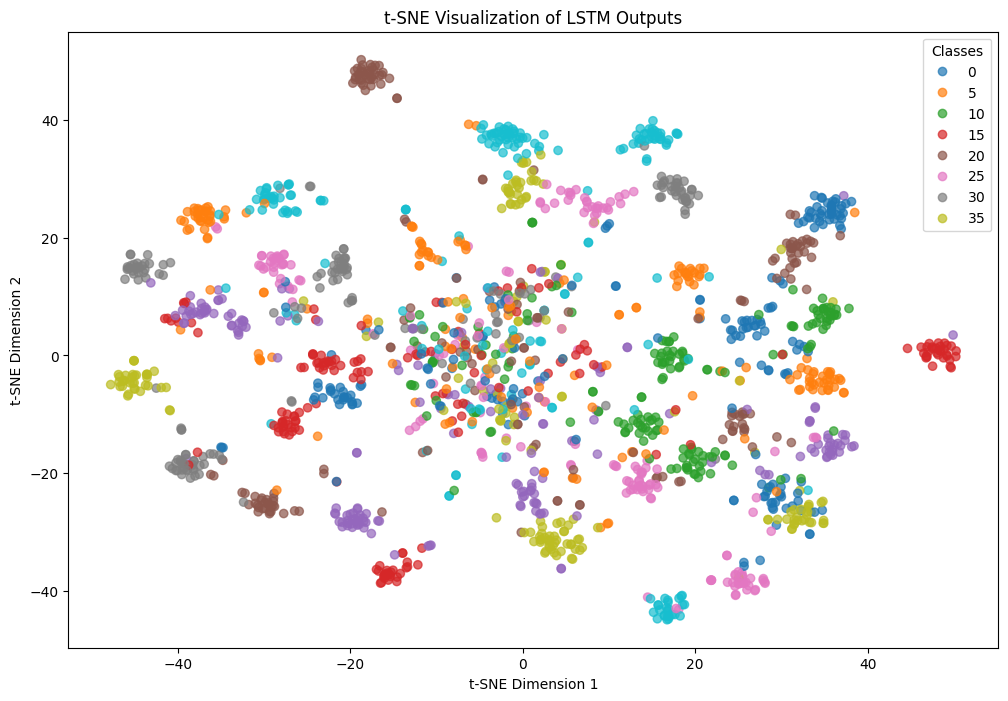

In [132]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test_int, cmap='tab10', alpha=0.7)
plt.title('t-SNE Visualization of LSTM Outputs')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(False)
plt.legend(*scatter.legend_elements(), title="Classes", loc="best")
plt.show()

# Save the Model, LabelEncoder and Scaler

for later use prediction

In [133]:
model.save('app/model/sign_language_recognition_new_40.keras')
joblib.dump(le, "app/model/label_encoder_new_40.pkl")
joblib.dump(scaler, "app/model/scaler_new_40.pkl")

['app/model/scaler_new_40.pkl']